In [43]:
def compute_attitude_angle(init_states,target_landing_point):
    u = init_state[0]
    v = init_state[1]
    w = init_state[2]

    p = init_state[3]
    q = init_state[4]
    r = init_state[5]

    pos_x = init_state[6]
    pos_y = init_state[7]
    pos_z = init_state[8]

    pos_phi_angle = init_state[9]
    pos_theta_angle = init_state[10]
    pos_psi_angle = init_state[11]

    vel_x = init_vel[0]
    vel_y = init_vel[1]
    vel_z = init_vel[2]

    target_x = target_landing_pointp[0] #desire_landing point
    target_y = target_landing_pointp[1] #desire_landing point
    target_z = target_landing_pointp[2] #maybe 0?

    #####################computing stage######################

    roll, pitch, yaw, thrust = compute_guidance_example()
    
    ##########################################################
    return roll,pitch,yaw

5


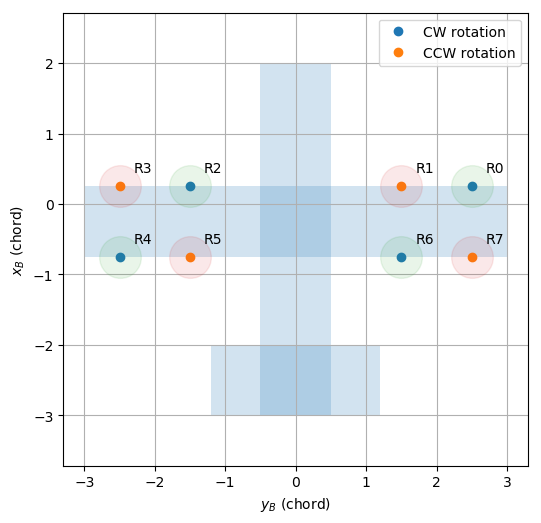

location:
 [[ 0.25  2.5   0.  ]
 [ 0.25  1.5   0.  ]
 [ 0.25 -1.5   0.  ]
 [ 0.25 -2.5   0.  ]
 [-0.75 -2.5   0.  ]
 [-0.75 -1.5   0.  ]
 [-0.75  1.5   0.  ]
 [-0.75  2.5   0.  ]]
moments:
 [[-2.75   0.275  0.   ]
 [-1.65   0.275  0.   ]
 [ 1.65   0.275  0.   ]
 [ 2.75   0.275  0.   ]
 [ 2.75  -0.825  0.   ]
 [ 1.65  -0.825  0.   ]
 [-1.65  -0.825 -0.   ]
 [-2.75  -0.825 -0.   ]]
A:
 [[ 1.1    1.1    1.1    1.1    1.1    1.1    1.1    1.1  ]
 [-2.75  -1.65   1.65   2.75   2.75   1.65  -1.65  -2.75 ]
 [ 0.275  0.275  0.275  0.275 -0.825 -0.825 -0.825 -0.825]
 [-0.52   0.52  -0.52   0.52  -0.52   0.52  -0.52   0.52 ]]


In [2]:
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

dt = 0.01            # control frequency
tf = 7             # final time
g = 9.8              # m/s^2

l = 1.0              # m
m = 23.56            # kg
Ix = 1.676           # kg m^2
Iy = 1.676           # kg m^2
Iz = 2.9743          # kg m^2

# rotor characteristics
kf = 1.1             # N / V^2
kt = 0.52            # N m / V^2 
rotor_limit = 10                  # rotor limit
rotor_sr_limit = rotor_limit/0.1  # rotor slew rate limit
omega_rotor, zeta_rotor = 40, 0.8

t_fail = 3         # 고장 시간
t_detect = 0.2     # 고장 검출에 걸리는 시간  
r_fail = 5         # 고장 로터 번호

c = l                 # chord length
nRotors = 8
loc = np.zeros((nRotors,3))
# rotor 0-7 position
# 0,2,4,6: positive yaw rotation
# 1,3,5,7: negative yaw rotation
loc[0] = np.array([ 0.25*c,  2.5*c, 0]) 
loc[1] = np.array([ 0.25*c,  1.5*c, 0])
loc[2] = np.array([ 0.25*c, -1.5*c, 0])
loc[3] = np.array([ 0.25*c, -2.5*c, 0])
loc[4] = np.array([-0.75*c, -2.5*c, 0])
loc[5] = np.array([-0.75*c, -1.5*c, 0])
loc[6] = np.array([-0.75*c,  1.5*c, 0])
loc[7] = np.array([-0.75*c,  2.5*c, 0])
thrust = np.array([0, 0, -kf])
moments = np.cross(loc, thrust)

plt.figure(num=1, figsize=(6,6), dpi=100)
plt.broken_barh([(-0.5, 1.0)], (-3.0,  5.0), alpha = 0.2) # fuselage
plt.broken_barh([(-3.0, 6.0)], (-0.75, 1.0), alpha = 0.2) # wing
plt.broken_barh([(-1.2, 2.4)], (-3.0,  1.0), alpha = 0.2) # tail
plt.plot(loc[0::2,1]/c, loc[0::2,0]/c, 'o', markersize=6, label='CW rotation')
plt.plot(loc[1::2,1]/c, loc[1::2,0]/c, 'o', markersize=6, label='CCW rotation')
plt.plot(loc[0::2,1]/c, loc[0::2,0]/c, 'o', alpha=0.1, markersize=30)
plt.plot(loc[1::2,1]/c, loc[1::2,0]/c, 'o', alpha=0.1, markersize=30)

for i in range(nRotors) :
    plt.text(loc[i,1]+0.2, loc[i,0]/c+0.2, 'R%i' %i)
    
plt.xlabel(r'$y_B$ (chord)')
plt.ylabel(r'$x_B$ (chord)')
plt.legend()
plt.axis('equal')
plt.grid()
plt.show()  

A = np.zeros((4,nRotors))        # rotor speed (sq) to control (thr/torque)
A[0,:] = np.ones(nRotors)*kf     # thrust
A[[1,2],:] = moments[:,[0,1]].T  # roll moment , pitch moment
A[3,0::2] = -kt                  # yaw moment (CW rotors) 
A[3,1::2] =  kt                  # yaw moment (CCW rotors)

print('location:\n',loc)
print('moments:\n', moments)
print('A:\n',A)

In [6]:
# guidance command computation
def compute_guidance(state, t, t_index):
    
    if not hasattr(compute_guidance, "counter"):
         compute_guidance.counter = 0
         compute_guidance.cmd0 = 0
         compute_guidance.cmd1 = 0
         compute_guidance.cmd2 = 0
         compute_guidance.cmd3 = 0
            
            
    u,v,w,p,q,r,x,y,z,phi,the,psi = state[:12]  # state variables(u,v,w : 기체중심 좌표 / p,q,r : 각속도 / x,y,z : NED 기준 좌표
                                                #                phi,the,psi : 자세각 )
    rotor = state[12:12+nRotors]
    rotor_dot = state[12+nRotors:]
    
    s_phi, c_phi = np.sin(phi), np.cos(phi)
    s_the, c_the = np.sin(the), np.cos(the)
    s_psi, c_psi = np.sin(psi), np.cos(psi)
    
    Cbn = np.array([ \
        [c_psi*c_the, c_psi*s_the*s_phi-s_psi*c_phi, c_psi*s_the*c_phi+s_psi*s_phi], \
        [s_psi*c_the, s_psi*s_the*s_phi+c_psi*c_phi, s_psi*s_the*c_phi-c_psi*s_phi], \
        [     -s_the,                   c_the*s_phi,                   c_the*c_phi] \
    ])

    x_dot,y_dot,z_dot = np.dot(Cbn,[u,v,w])
    h_dot = -z_dot
    h = -z
    
    omg_alt, zet_alt = 2, 0.8
    omg_pos, zet_pos = 2, 0.8
    
    # NED 좌표 기준 위치 명령 h, x, y와 자세각 명령 psi
    if t < t_fail+t_detect:
        
        # 고장 전 자세 명령 산출 loop
        
        h_cmd = 1
        x_cmd = 1
        y_cmd = 2
        psi_cmd = 10*Deg2Rad
    
        # altitude loop
        up_cmd = -2*zet_alt*omg_alt*h_dot + omg_alt**2*(h_cmd-h) + g
        thrust = m*up_cmd/(c_phi*c_the)

        # horizontal position loop
        ax_cmd = -2*zet_pos*omg_pos*x_dot + omg_pos**2*(x_cmd-x)
        ay_cmd = -2*zet_pos*omg_pos*y_dot + omg_pos**2*(y_cmd-y)
        au_cmd, av_cmd, aw_cmd = np.dot(Cbn.T,[ax_cmd,ay_cmd,0])
        the_cmd = np.arctan2(-au_cmd,g)
        phi_cmd = np.arctan2( av_cmd,g)
    
    else :
        
        # 고장 검출 후 자세 명령 산출 loop(compute_guidance_cvx함수로 계산)
        
        if (compute_guidance.counter%5==0):
            thrust, phi_cmd, the_cmd, psi_cmd = compute_guidance_cvx([x,y,z],[x_dot,y_dot,z_dot],psi,tf-t)
            compute_guidance.cmd0 = thrust
            compute_guidance.cmd1 = phi_cmd
            compute_guidance.cmd2 = the_cmd
            compute_guidance.cmd3 = psi_cmd
            
        else:
            thrust = compute_guidance.cmd0
            phi_cmd = compute_guidance.cmd1
            the_cmd = compute_guidance.cmd2
            psi_cmd = compute_guidance.cmd3
        
        compute_guidance.counter += 1
        
    return np.array([thrust, phi_cmd, the_cmd, psi_cmd])


'''
    elif t < t_fail+t_detect:
        h_cmd = 2.5
        x_cmd = 0.4
        y_cmd = 0.6
        psi_cmd = 0*Deg2Rad
    
        # altitude looppinvA
        up_cmd = -2*zet_alt*omg_alt*h_dot + omg_alt**2*(h_cmd-h) + g
        thrust = m*up_cmd/(c_phi*c_the)

        # horizontal position loop
        ax_cmd = -2*zet_pos*omg_pos*x_dot + omg_pos**2*(x_cmd-x)
        ay_cmd = -2*zet_pos*omg_pos*y_dot + omg_pos**2*(y_cmd-y)
        au_cmd, av_cmd, aw_cmd = np.dot(Cbn.T,[ax_cmd,ay_cmd,0])
        the_cmd = np.arctan2(-au_cmd,g)
        phi_cmd = np.arctan2( av_cmd,g)
        '''

# guidance command computation_convex
def  compute_guidance_cvx(position, velocity, psi, tgo):
    delt = 0.05
    T = tgo
    N = int(T/delt)

    r_des = np.zeros(3)
    r_des[0] = 1
    r_des[1] = 1
    r_des[2] = 0

    v_des = np.zeros(3)

    g_pin = np.zeros(3)
    g_pin[2] = 9.8
    T2 = 720

    T_c = cp.Variable((3,N+1))
    r_pin = cp.Variable((3,N+1))
    v_pin = cp.Variable((3,N+1))

    mag = cp.norm(T_c,axis=0)
    obj = cp.Minimize(cp.norm(mag))    

    constr = [ 
        v_pin[:,0] == velocity,
        r_pin[:,0] == position,
        v_pin[:,-1] == v_des,
        r_pin[:,-1] == r_des,
        #r_pin[2,-1] == 0,
        ]
    
    # 3축 최적 추력 명령 산출
    
    for t in range(N):
        constr += [        
            #r_pin[:,t+1] == r_pin[:,t] + 0.5*delt*(v_pin[:,t]+v_pin[:,t+1]) + delt**2/12*(T_c[:,t+1]/m-T_c[:,t]/m),
            #v_pin[:,t+1] == v_pin[:,t] + 0.5*delt*(T_c[:,t]/m+T_c[:,t+1]/m) + g_pin*delt,
            r_pin[:,t+1] == r_pin[:,t] + v_pin[:,t]*delt,
            v_pin[:,t+1] == v_pin[:,t] + (T_c[:,t]/m+g_pin)*delt,
            cp.norm(T_c[:,t]) <= T2,
            T_c[2,t]<=0,
        ]

    prob = cp.Problem(obj, constr)
    prob.solve(verbose=False,solver=cp.ECOS)

    if prob.status=='optimal' or prob.status=='optimal_inaccurate':
        T_n, T_e, T_d = T_c.value[:,0]
#        T_e = T_c.value[1,0]
#        T_d = T_c.value[2,0]
    
    # 추력 명령 -> 자세각 명령 변환 loop
    
        T_a =  T_n*np.cos(psi) + T_e*np.sin(psi)
        T_b = -T_n*np.sin(psi) + T_e*np.cos(psi)
    
        thrust = np.sqrt(T_d**2+T_n**2+T_e**2)
        the_cmd = -np.arctan2(T_a,-T_d)
        phi_cmd = np.arcsin(T_b/thrust)
        psi_cmd = psi
        print(tgo, prob.status)
       
    else:
        thrust, phi_cmd, the_cmd, psi_cmd = 0, 0, 0, 0
        print(tgo, prob.status)
    
    if position[2]>=0:
        thrust, phi_cmd, the_cmd, psi_cmd = 0, 0, 0, 0 

    return np.array([thrust,phi_cmd,the_cmd,psi_cmd])

# control computation
def compute_control(guidance_cmd, state, t):
    
    u,v,w,p,q,r,x,y,z,phi,the,psi = state[:12]  # state variables
    thrust, phi_cmd, the_cmd, psi_cmd = guidance_cmd
    
    #loop gain
    
    omg_phi, zet_phi = 8, 0.7
    omg_the, zet_the = 8, 0.7
    omg_psi, zet_psi = 4, 0.9
    
    #자세각 명령으로부터 토크 명령 산출
    
    torque_phi = -2*zet_phi*omg_phi*p + omg_phi**2*(phi_cmd-phi)
    torque_the = -2*zet_the*omg_the*q + omg_the**2*(the_cmd-the)
    torque_psi = -2*zet_psi*omg_psi*r + omg_psi**2*(psi_cmd-psi)
    torque_phi *= Ix
    torque_the *= Iy
    torque_psi *= Iz
        
    return np.array([thrust,torque_phi,torque_the,torque_psi])


# 로터 회전수 산출
def mix_actuators(control):
    rotor = pinvA@control
    return np.sqrt(np.clip(rotor,0,100))

# 로터 회전수 산출(cvx)
def mix_actuators_cvx(control, r_p, k, flag_fail):
    import cvxpy as cp
    W = np.diag([1, 1, 1, 1])
    
    r = cp.Variable(nRotors,nonneg=True)
    obj_req = cp.sum_squares(W@(A@r-control))
    obj_smooth = 1e-4*cp.sum_squares(r-r_p)
    #obj_card = 0.1*cp.norm(r,1)
    #obj_max = 0.01*cp.max(r)
    #obj_energy = 1e-6*cp.sum_squares(r)
    #obj = cp.Minimize( obj_req + obj_smooth + obj_card )
    obj = cp.Minimize( obj_req + obj_smooth)
    constr = [ r <= 100 ]
    if flag_fail and k*dt > t_fail + t_detect:
        constr += [r[r_fail]==0]
    cp.Problem(obj, constr).solve(verbose=False)
    rotor = r.value
    return np.sqrt(np.clip(rotor,0,100))


In [8]:
pinvA = np.linalg.pinv(A)

# quadrotor 6DOF dynamics
def state_derivative(state, t, rotor_cmd, flag_fail):  # computes state derivatives  
    u,v,w,p,q,r,x,y,z,phi,the,psi = state[:12]         # state variables
    rotor = state[12:12+nRotors]         
    rotor_dot = state[12+nRotors:]  
    rotor = np.clip(rotor, 0, rotor_limit)                           # rotor limit
    rotor_dot = np.clip(rotor_dot, -rotor_sr_limit, rotor_sr_limit)  # rotor speed slew rate limit
    if flag_fail and t > t_fail:
        state[12+r_fail] = 0
        rotor[r_fail] = 0
        rotor_dot[r_fail] = 0
    T,L,M,N = A@(rotor**2)                           # control variable
 
    s_phi, c_phi = np.sin(phi), np.cos(phi)
    s_the, c_the = np.sin(the), np.cos(the)
    s_psi, c_psi = np.sin(psi), np.cos(psi)
    
    u_dot   = -g*s_the       - (q*w - r*v)
    v_dot   =  g*c_the*s_phi - (r*u - p*w)
    w_dot   =  g*c_the*c_phi - (p*v - q*u) - T/m
    
    if z>0:
        u_dot -= -g*s_the
        v_dot -=  g*c_the*s_phi
        w_dot -=  g*c_the*c_phi
    
    p_dot   = -(Iz-Iy)/Ix*q*r + L/Ix 
    q_dot   = -(Ix-Iz)/Iy*r*p + M/Iy
    r_dot   = -(Iy-Ix)/Iz*p*q + N/Iz
    
    Cbn = np.array([ \
        [c_psi*c_the, c_psi*s_the*s_phi-s_psi*c_phi, c_psi*s_the*c_phi+s_psi*s_phi], \
        [s_psi*c_the, s_psi*s_the*s_phi+c_psi*c_phi, s_psi*s_the*c_phi-c_psi*s_phi], \
        [     -s_the,                   c_the*s_phi,                   c_the*c_phi] \
    ])
    
    x_dot,y_dot,z_dot = np.dot(Cbn,np.array([u,v,w]))
    
    phi_dot = p + s_phi*s_the/c_the*q + c_phi*s_the/c_the*r
    the_dot =                 c_phi*q -             s_phi*r
    psi_dot =           s_phi/c_the*q +       c_phi/c_the*r
    
    rotor_ddot = -2*zeta_rotor*omega_rotor*rotor_dot \
                  + omega_rotor**2*(rotor_cmd-rotor)

    return np.array([u_dot,v_dot,w_dot,p_dot,q_dot,r_dot,x_dot,y_dot,z_dot, \
                     phi_dot,the_dot,psi_dot,*rotor_dot,*rotor_ddot])



In [10]:
# simulation 초기값 설정

u0, v0, w0 = 0, 0, 0
p0, q0, r0 = 0, 0, 0
x0, y0, z0 = 0, 0, 0
phi0, the0, psi0 = 0, 0, 0
rotor0 = np.zeros(nRotors)
rotor_dot0 = np.zeros(nRotors)
X0 = np.array([u0,v0,w0,p0,q0,r0,x0,y0,z0,phi0,the0,psi0,*rotor0,*rotor_dot0])
G0 = np.zeros(4)
U0 = np.zeros(4)
R0 = np.zeros(nRotors)
t = np.arange(0,tf, dt)
n = len(t)
X = np.zeros((len(X0),n))
dX = np.zeros((len(X0),n))
G = np.zeros((len(G0),n-1))
U = np.zeros((len(U0),n-1))
R = np.zeros((len(R0),n-1))
X[:,0] = X0
G[:,0] = G0
U[:,0] = U0
R[:,0] = R0

dotX_p = X0*0

#simulation loop
for k in range(n-1):
    
    G[:,k] = compute_guidance(X[:,k],t[k],k)
    U[:,k] = compute_control(G[:,k],X[:,k],t[k])
    if k==0:
        R_p = np.zeros(nRotors)
    else:
        R_p = R[:,k-1]**2
    if k%100==0:
        print(k, end=' ')
    R[:,k] = mix_actuators_cvx(U[:,k],R_p, k, True)
    dotX = state_derivative(X[:,k],t[k],R[:,k], True)  # fail sim
    dX[:,k+1] = dotX
    X[:,k+1] = X[:,k] + 0.5*(3*dotX-dotX_p)*dt
    dotX_p = dotX

    if t[k]>1 and X[8,k+1]>0:
        X[:,k+2:] = X[:,k+1].reshape(-1,1)
        break

        
X_ca1, G_ca1, U_ca1, R_ca1 = X, G, U, R
dX_ca1 = dX
Rr_ca1 = X_ca1[12:12+nRotors,:-1]
Ur_ca1 = A@(Rr_ca1**2)
X_ca2, U_ca2, R_ca2 = X_ca1, U_ca1, R_ca1
dX_ca1 = dX
Rr_ca2 = Rr_ca1
Ur_ca2 = Ur_ca1

01002003003.8 optimal_inaccurate
3.75 optimal
3.6999999999999997 optimal
3.65 optimal
3.6 optimal
3.55 optimal
3.5 optimal
3.4499999999999997 optimal
3.4 optimal
3.35 optimal
3.3 optimal
3.25 optimal
3.1999999999999997 optimal
3.15 optimal
3.1 optimal
3.05 optimal
3.0 optimal
4002.95 optimal
2.9000000000000004 optimal
2.8499999999999996 optimal
2.8 optimal
2.75 optimal
2.7 optimal
2.6499999999999995 optimal
2.5999999999999996 optimal
2.55 optimal
2.5 optimal
2.45 optimal
2.3999999999999995 optimal
2.3499999999999996 optimal
2.3 optimal
2.25 optimal
2.2 optimal
2.1499999999999995 optimal
2.0999999999999996 optimal
2.05 optimal
2.0 optimal_inaccurate
5001.9500000000000002 optimal
1.8999999999999995 optimal
1.8499999999999996 optimal
1.7999999999999998 optimal
1.75 optimal
1.7000000000000002 optimal_inaccurate
1.6499999999999995 optimal
1.5999999999999996 optimal_inaccurate
1.5499999999999998 optimal
1.5 optimal_inaccurate
1.4500000000000002 optimal_inaccurate
1.3999999999999995 optimal
1

In [12]:
u0, v0, w0 = 0, 0, 0
p0, q0, r0 = 0, 0, 0
x0, y0, z0 = 0, 0, 0
phi0, the0, psi0 = 0, 0, 0
rotor0 = np.zeros(nRotors)
rotor_dot0 = np.zeros(nRotors)
X0 = np.array([u0,v0,w0,p0,q0,r0,x0,y0,z0,phi0,the0,psi0,*rotor0,*rotor_dot0])
G0 = np.zeros(4)
U0 = np.zeros(4)
R0 = np.zeros(nRotors)
t = np.arange(0,tf, dt)
n = len(t)
X = np.zeros((len(X0),n))
dX = np.zeros((len(X0),n))
G = np.zeros((len(G0),n-1))
U = np.zeros((len(U0),n-1))
R = np.zeros((len(R0),n-1))
X[:,0] = X0
G[:,0] = G0
U[:,0] = U0
R[:,0] = R0

dotX_p = X0*0

for k in range(n-1):
    
    G[:,k] = compute_guidance(X[:,k],t[k],k)
    U[:,k] = compute_control(G[:,k],X[:,k],t[k])
    if k==0:
        R_p = np.zeros(nRotors)
    else:
        R_p = R[:,k-1]**2
    if k%100==0:
        print(k, end=' ')
    R[:,k] = mix_actuators_cvx(U[:,k],R_p, k, False)
    dotX = state_derivative(X[:,k],t[k],R[:,k], False)  
    dX[:,k+1] = dotX
    X[:,k+1] = X[:,k] + 0.5*(3*dotX-dotX_p)*dt
    dotX_p = dotX

    if t[k]>1 and X[8,k+1]>0:
        X[:,k+2:] = X[:,k+1].reshape(-1,1)
        break

        
X_ca2, G_ca2, U_ca2, R_ca2 = X, G, U, R
dX_ca2 = dX
Rr_ca2 = X_ca2[12:12+nRotors,:-1]
Ur_ca2 = A@(Rr_ca2**2)
dX_ca2 = dX


01002003003.8 optimal_inaccurate
3.75 optimal_inaccurate
3.6999999999999997 optimal_inaccurate
3.65 optimal_inaccurate
3.6 optimal
3.55 optimal_inaccurate
3.5 optimal_inaccurate
3.4499999999999997 optimal_inaccurate
3.4 optimal
3.35 optimal_inaccurate
3.3 optimal_inaccurate
3.25 optimal_inaccurate
3.1999999999999997 optimal_inaccurate
3.15 optimal
3.1 optimal_inaccurate
3.05 optimal_inaccurate
3.0 optimal
4002.95 optimal_inaccurate
2.9000000000000004 optimal
2.8499999999999996 optimal_inaccurate
2.8 optimal
2.75 optimal_inaccurate
2.7 optimal
2.6499999999999995 optimal_inaccurate
2.5999999999999996 optimal
2.55 optimal
2.5 optimal_inaccurate
2.45 optimal_inaccurate
2.3999999999999995 optimal_inaccurate
2.3499999999999996 optimal_inaccurate
2.3 optimal_inaccurate
2.25 optimal_inaccurate
2.2 optimal
2.1499999999999995 optimal
2.0999999999999996 optimal_inaccurate
2.05 optimal
2.0 optimal
5001.9500000000000002 optimal_inaccurate
1.8999999999999995 optimal_inaccurate
1.8499999999999996 opt

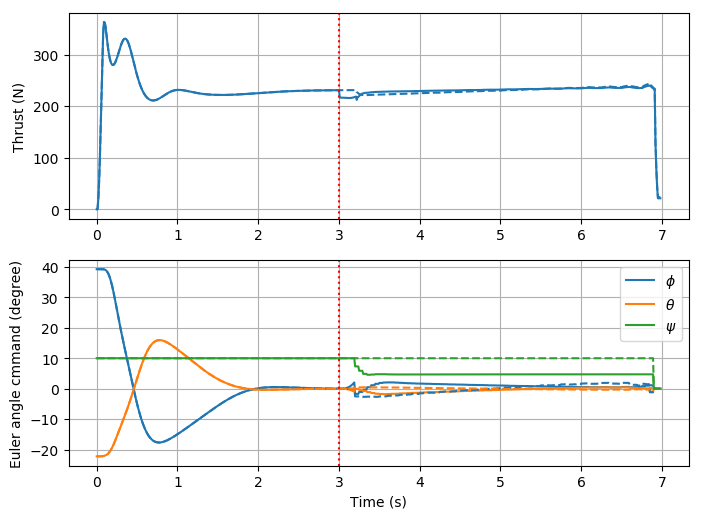

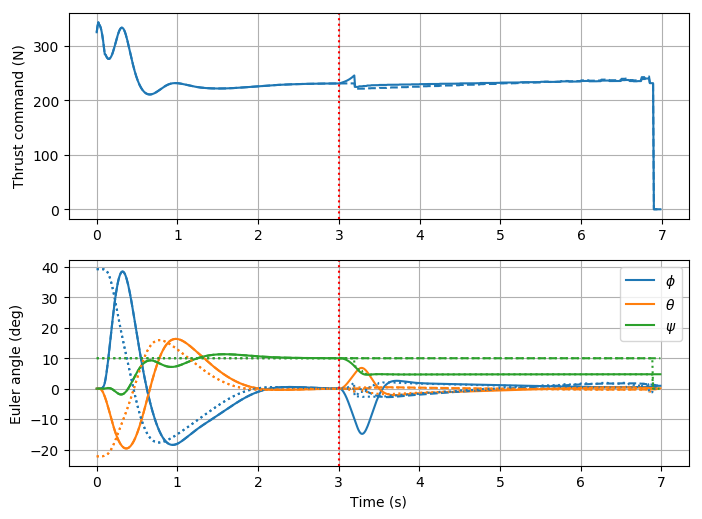

"\nplt.subplot(212)\nfor i in range(3):\n    plt.plot(t[:-1], Ur_ca1[i+1,:], color=colors[i])\n#for i in range(3):\n#    plt.plot(t[:-1], Ur_ca2[i+1,:], '--', color=colors[i])\nplt.axvline(t_fail, linestyle=':',  color='r')\nplt.xlabel('Time (s)')\nplt.ylabel('Torque (Nm)')\nplt.legend([r'$\tau_{\\phi}$',r'$\tau_{\theta}$',r'$\tau_{\\psi}$'])\nplt.grid()\nplt.show()\n"

In [14]:
cmap = plt.get_cmap("tab20")
colors = cmap([0,2,4,6,8,10,12,14])

plt.figure(num=2, figsize=(8,6), dpi=100)
plt.subplot(211)
plt.plot(t[:-1], Ur_ca1[0,:], color=colors[0])
plt.plot(t[:-1], Ur_ca2[0,:], '--', color=colors[0])
plt.axvline(t_fail, linestyle=':', color='r')
plt.ylabel('Thrust (N)')
plt.grid()
plt.subplot(212)
for i in range(3):
    plt.plot(t[:-1], G_ca1[i+1,:]*Rad2Deg, color=colors[i])
for i in range(3):
    plt.plot(t[:-1], G_ca2[i+1,:]*Rad2Deg, '--', color=colors[i])
plt.axvline(t_fail, linestyle=':',  color='r')
plt.xlabel('Time (s)')
#plt.xlim(3,4)
plt.ylabel('Euler angle cmmand (degree)')
plt.legend([r'$\phi$',r'$\theta$',r'$\psi$'], loc='upper right')
plt.grid()
plt.show()
plt.figure(num=2, figsize=(8,6), dpi=100)
plt.subplot(211)
plt.plot(t[:-1], G_ca1[0,:], color=colors[0])
plt.plot(t[:-1], G_ca2[0,:], '--', color=colors[0])
plt.axvline(t_fail, linestyle=':', color='r')
plt.ylabel('Thrust command (N)')
plt.grid()
plt.subplot(212)
for i in range(3):
    plt.plot(t, X_ca1[i+9,:]*Rad2Deg, color=colors[i])
for i in range(3):
    plt.plot(t, X_ca2[i+9,:]*Rad2Deg, '--', color=colors[i])
for i in range(3):
    plt.plot(t[:-1], G_ca1[i+1,:]*Rad2Deg, ':', color=colors[i])
for i in range(3):
    plt.plot(t[:-1], G_ca2[i+1,:]*Rad2Deg, ':', color=colors[i])
    
plt.axvline(t_fail, linestyle=':',  color='r')
plt.xlabel('Time (s)')
plt.ylabel('Euler angle (deg)')
#plt.ylim(-25,25)
plt.legend([r'$\phi$',r'$\theta$',r'$\psi$'])
plt.grid()
plt.show()
'''
plt.subplot(212)
for i in range(3):
    plt.plot(t[:-1], Ur_ca1[i+1,:], color=colors[i])
#for i in range(3):
#    plt.plot(t[:-1], Ur_ca2[i+1,:], '--', color=colors[i])
plt.axvline(t_fail, linestyle=':',  color='r')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend([r'$\tau_{\phi}$',r'$\tau_{\theta}$',r'$\tau_{\psi}$'])
plt.grid()
plt.show()
'''

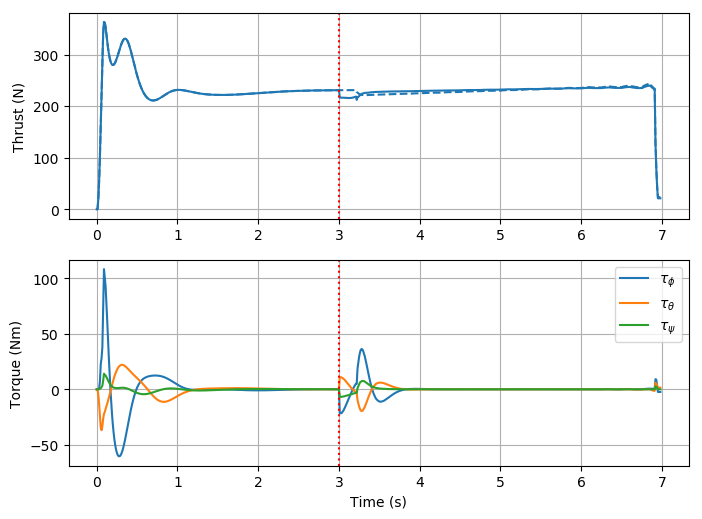

In [16]:
plt.figure(num=2, figsize=(8,6), dpi=100)
plt.subplot(211)
plt.plot(t[:-1], Ur_ca1[0,:], color=colors[0])
plt.plot(t[:-1], Ur_ca2[0,:], '--', color=colors[0])
plt.axvline(t_fail, linestyle=':', color='r')
plt.ylabel('Thrust (N)')
plt.grid()
plt.subplot(212)
for i in range(3):
    plt.plot(t[:-1], Ur_ca1[i+1,:], color=colors[i])
#for i in range(3):
#    plt.plot(t[:-1], Ur_ca2[i+1,:], '--', color=colors[i])
plt.axvline(t_fail, linestyle=':',  color='r')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend([r'$\tau_{\phi}$',r'$\tau_{\theta}$',r'$\tau_{\psi}$'])
plt.grid()
plt.show()

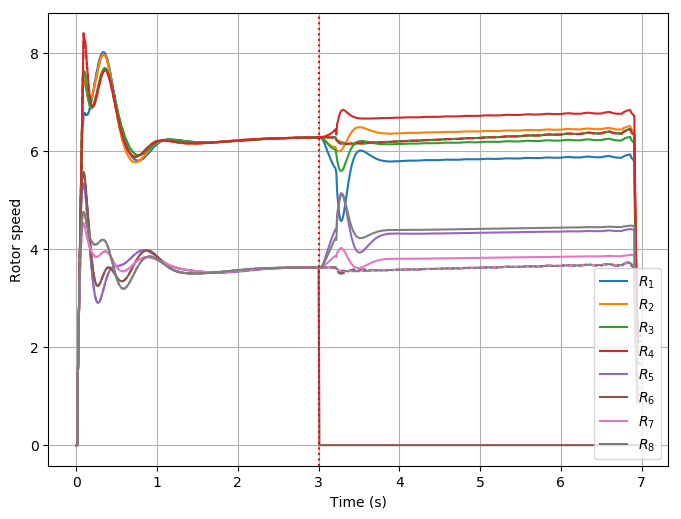

"\nplt.figure(num=4, figsize=(8,12), dpi=100)\nplt.title('Rotor speed')\nfor i in range(nRotors):\n    plt.subplot(nRotors, 1, i+1)\n    plt.plot(t[:-1], (Rr_ca1[i,:]), color=colors[i], label='$R_{%i}$'%(i+1))\n    plt.plot(t[:-1], (Rr_ca2[i,:]), '--', color=colors[i])\n    plt.axvline(t_fail, linestyle=':',  color='r')\n    plt.ylim(0,10)\n    plt.legend()\n    plt.grid()\nplt.show()\n\nplt.figure(num=5, figsize=(47,6), dpi=100)\nplt.title('Rotor voltage (V)')\nfor i in range(nRotors):\n    plt.subplot(1, nRotors, i+1)\n    plt.plot(t[:-1], (Rr_ca1[i,:]), color=colors[i], label='$R_{%i}$'%(i+1))\n    plt.plot(t[:-1], (Rr_ca2[i,:]), '--', color=colors[i])\n    plt.axvline(t_fail, linestyle=':',  color='r')\n    plt.ylim(0,10)\n    plt.legend()\n    plt.grid()\nplt.show()\n"

In [18]:
plt.figure(num=3, figsize=(8,6), dpi=100)
for i in range(nRotors):
    plt.plot(t[:-1], (Rr_ca1[i,:]), color=colors[i], label='$R_{%i}$'%(i+1))
    plt.plot(t[:-1], (Rr_ca2[i,:]), '--', color=colors[i])
plt.axvline(t_fail, linestyle=':',  color='r')
plt.ylabel('Rotor speed')
plt.xlabel('Time (s)')
plt.legend()
#plt.xlim(0,1)
plt.grid()
plt.show()

'''
plt.figure(num=4, figsize=(8,12), dpi=100)
plt.title('Rotor speed')
for i in range(nRotors):
    plt.subplot(nRotors, 1, i+1)
    plt.plot(t[:-1], (Rr_ca1[i,:]), color=colors[i], label='$R_{%i}$'%(i+1))
    plt.plot(t[:-1], (Rr_ca2[i,:]), '--', color=colors[i])
    plt.axvline(t_fail, linestyle=':',  color='r')
    plt.ylim(0,10)
    plt.legend()
    plt.grid()
plt.show()

plt.figure(num=5, figsize=(47,6), dpi=100)
plt.title('Rotor voltage (V)')
for i in range(nRotors):
    plt.subplot(1, nRotors, i+1)
    plt.plot(t[:-1], (Rr_ca1[i,:]), color=colors[i], label='$R_{%i}$'%(i+1))
    plt.plot(t[:-1], (Rr_ca2[i,:]), '--', color=colors[i])
    plt.axvline(t_fail, linestyle=':',  color='r')
    plt.ylim(0,10)
    plt.legend()
    plt.grid()
plt.show()
'''

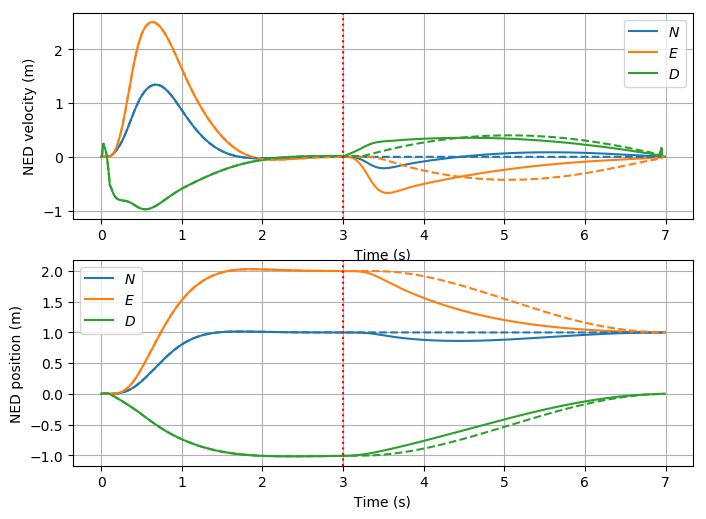

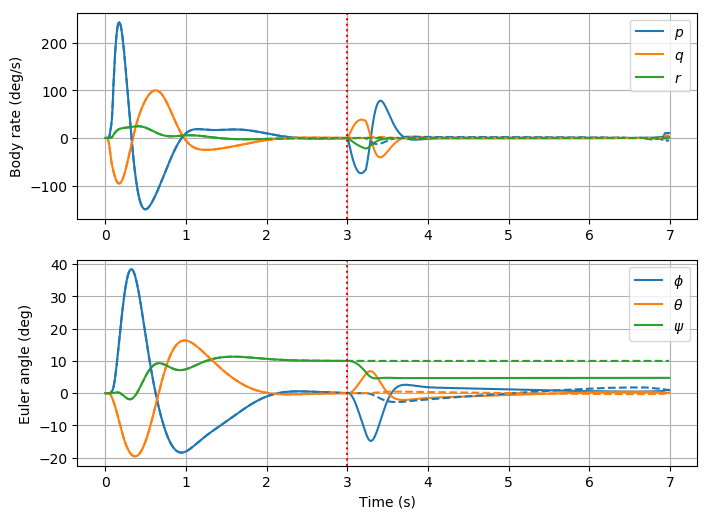

In [20]:
plt.figure(num=6, figsize=(8,6), dpi=100)
plt.subplot(211)
for i in range(3):
    plt.plot(t, dX_ca1[i+6,:], color=colors[i])
for i in range(3):
    plt.plot(t, dX_ca2[i+6,:], '--', color=colors[i])
plt.axvline(t_fail, linestyle=':',  color='r')
plt.xlabel('Time (s)')
plt.ylabel('NED velocity (m)')
#plt.xlim(2,3)
plt.legend([r'$N$',r'$E$',r'$D$'])
plt.grid()
'''
plt.subplot(212)
for i in range(3):
    plt.plot(t[:-1], G_ca1[i+7,:], color=colors[i])
    #plt.plot(t, G_ca1[i+3,:], color=colors[i])
#for i in range(3):
#    plt.plot(t, X_ca2[i,:], '--', color=colors[i])
plt.axvline(t_fail, linestyle=':',  color='r')
plt.ylabel('NED velocity command (m/s)')
#plt.ylim(-1.6,1.6)
plt.legend([r'$N$',r'$E$',r'$D$'])
plt.grid()
plt.show()
'''

plt.figure(num=6, figsize=(8,6), dpi=100)
'''
plt.subplot(211)
for i in range(3):
    plt.plot(t[:-1], G_ca1[i+4,:], color=colors[i])
    #plt.plot(t, G_ca1[i+3,:], color=colors[i])
#for i in range(3):
#    plt.plot(t, X_ca2[i,:], '--', color=colors[i])
plt.axvline(t_fail, linestyle=':',  color='r')
plt.ylabel('NED command (m)')
#plt.ylim(-1.6,1.6)
plt.legend([r'$N$',r'$E$',r'$D$'])
plt.grid()
'''
plt.subplot(212)
for i in range(3):
    plt.plot(t, X_ca1[i+6,:], color=colors[i])
for i in range(3):
    plt.plot(t, X_ca2[i+6,:], '--', color=colors[i])
plt.axvline(t_fail, linestyle=':',  color='r')
plt.xlabel('Time (s)')
plt.ylabel('NED position (m)')
#plt.ylim(-1,1)
plt.legend([r'$N$',r'$E$',r'$D$'])
plt.grid()
plt.show()

plt.figure(num=7, figsize=(8,6), dpi=100)
plt.subplot(211)
for i in range(3):
    plt.plot(t, X_ca1[i+3,:]*Rad2Deg, color=colors[i])
for i in range(3):
    plt.plot(t, X_ca2[i+3,:]*Rad2Deg, '--', color=colors[i])
plt.axvline(t_fail, linestyle=':',  color='r')
plt.ylabel('Body rate (deg/s)')
#plt.ylim(-150,150)
plt.legend([r'$p$',r'$q$',r'$r$'])
plt.grid()
plt.subplot(212)
for i in range(3):
    plt.plot(t, X_ca1[i+9,:]*Rad2Deg, color=colors[i])
for i in range(3):
    plt.plot(t, X_ca2[i+9,:]*Rad2Deg, '--', color=colors[i])
plt.axvline(t_fail, linestyle=':',  color='r')
plt.xlabel('Time (s)')
plt.ylabel('Euler angle (deg)')
#plt.ylim(-25,25)
plt.legend([r'$\phi$',r'$\theta$',r'$\psi$'])
plt.grid()
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(8,6), dpi=100)
plt.gca(projection='3d')
plt.plot(X_ca1[7,:], X_ca1[6,:], -X_ca1[8,:], color=colors[0], alpha=1.0, linewidth=2, label='Fault')
plt.plot(X_ca2[7,:], X_ca2[6,:], -X_ca2[8,:], '--', color=colors[0], alpha=1.0, linewidth=2, label='Normal')
plt.plot(X_ca2[7,[int(t_fail/dt),int(t_fail/dt)]], X_ca2[6,[int(t_fail/dt),int(t_fail/dt)]], -X_ca2[8,[int(t_fail/dt),int(t_fail/dt)]], 'r*', markersize=10)
plt.plot(X_ca2[7,[int((t_fail+t_detect)/dt),int((t_fail+t_detect)/dt)]], X_ca2[6,[int((t_fail+t_detect)/dt),int((t_fail+t_detect)/dt)]], -X_ca2[8,[int((t_fail+t_detect)/dt),int((t_fail+t_detect)/dt)]], 'b^', markersize=10)
plt.xlabel('East (m)')
plt.ylabel('North (m)')
#plt.zlabel('h (m)')
plt.legend()
plt.show()

plt.figure(figsize=(8,6), dpi=100)
plt.plot(X_ca1[7,:], X_ca1[6,:], color=colors[0], alpha=1.0, linewidth=2)
plt.plot(X_ca2[7,:], X_ca2[6,:], '--', color=colors[0], alpha=1.0, linewidth=2)
plt.plot(X_ca2[7,[int(t_fail/dt),int(t_fail/dt)]], X_ca2[6,[int(t_fail/dt),int(t_fail/dt)]], 'r*', markersize=10)
plt.plot(X_ca2[7,[int((t_fail+t_detect)/dt),int((t_fail+t_detect)/dt)]], X_ca2[6,[int((t_fail+t_detect)/dt),int((t_fail+t_detect)/dt)]], 'b^', markersize=10)
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.axis('equal')
plt.grid()
plt.show()

plt.figure(figsize=(8,6), dpi=100)
plt.plot(X_ca1[7,:], -X_ca1[8,:], color=colors[0], alpha=1.0, linewidth=2)
plt.plot(X_ca2[7,:], -X_ca2[8,:], '--', color=colors[0], alpha=1.0, linewidth=2)
plt.plot(X_ca2[7,[int(t_fail/dt),int(t_fail/dt)]], -X_ca2[8,[int(t_fail/dt),int(t_fail/dt)]], 'r*', markersize=10)
plt.plot(X_ca2[7,[int((t_fail+t_detect)/dt),int((t_fail+t_detect)/dt)]], -X_ca2[8,[int((t_fail+t_detect)/dt),int((t_fail+t_detect)/dt)]], 'b^', markersize=10)
plt.xlabel('East (m)')
plt.ylabel('Altitude (m)')
plt.axis('equal')
plt.grid()
plt.show()

In [23]:
'''
#3D animation
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

thrust_vec = np.zeros((3,len(dX_ca1[6,:])-1))

for i in range(len(dX_ca1[6,:])-1):
    thrust_vec[0,i] =Ur_ca1[0,i]  * (dX_ca1[6,i+1]- dX_ca1[6,i])/dt
    thrust_vec[1,i] =Ur_ca1[0,i]  * (dX_ca1[7,i+1]- dX_ca1[7,i])/dt
    thrust_vec[2,i] =Ur_ca1[0,i]  * ((dX_ca1[8,i+1]- dX_ca1[8,i])/dt+g)


X_new = X_ca1[7,:-1]
Y_new = X_ca1[6,:-1]
Z_new = X_ca1[8,:-1]

def get_arrow(i):
    x = X_new[i]
    y = Y_new[i]
    z = -Z_new[i]
    u = 10e-5* thrust_vec[0,i]
    v = 10e-5* thrust_vec[1,i]
    w = 10e-5* thrust_vec[2,i]
    return x,y,z,u,v,w

fig, ax = plt.subplots(subplot_kw=dict(projection="3d"))
quiver = ax.quiver(*get_arrow(0))

ax.plot(X_new[:], Y_new[:], -Z_new[:],label="Problem1",color ='green',alpha=0.2)
plt.plot(X_ca2[7,[int(t_fail/dt),int(t_fail/dt)]], X_ca2[6,[int(t_fail/dt),int(t_fail/dt)]], -X_ca2[8,[int(t_fail/dt),int(t_fail/dt)]], '*', markersize=10)
ax.legend()
def update(i):
    global quiver
    quiver.remove()
    quiver = ax.quiver(*get_arrow(i),color='r',arrow_length_ratio=0)

ani = FuncAnimation(fig, update, frames=int(tf/dt)-1, interval=10)




Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800, extra_args=['-vcodec', 'libx264'])
ani.save('Sim3.mp4', writer=writer,dpi = 300)
'''

'\n#3D animation\nfrom matplotlib.ticker import LinearLocator, FormatStrFormatter\nfrom matplotlib.animation import FuncAnimation\nimport matplotlib.animation as animation\n\nthrust_vec = np.zeros((3,len(dX_ca1[6,:])-1))\n\nfor i in range(len(dX_ca1[6,:])-1):\n    thrust_vec[0,i] =Ur_ca1[0,i]  * (dX_ca1[6,i+1]- dX_ca1[6,i])/dt\n    thrust_vec[1,i] =Ur_ca1[0,i]  * (dX_ca1[7,i+1]- dX_ca1[7,i])/dt\n    thrust_vec[2,i] =Ur_ca1[0,i]  * ((dX_ca1[8,i+1]- dX_ca1[8,i])/dt+g)\n\n\nX_new = X_ca1[7,:-1]\nY_new = X_ca1[6,:-1]\nZ_new = X_ca1[8,:-1]\n\ndef get_arrow(i):\n    x = X_new[i]\n    y = Y_new[i]\n    z = -Z_new[i]\n    u = 10e-5* thrust_vec[0,i]\n    v = 10e-5* thrust_vec[1,i]\n    w = 10e-5* thrust_vec[2,i]\n    return x,y,z,u,v,w\n\nfig, ax = plt.subplots(subplot_kw=dict(projection="3d"))\nquiver = ax.quiver(*get_arrow(0))\n\nax.plot(X_new[:], Y_new[:], -Z_new[:],label="Problem1",color =\'green\',alpha=0.2)\nplt.plot(X_ca2[7,[int(t_fail/dt),int(t_fail/dt)]], X_ca2[6,[int(t_fail/dt),int(t_

In [ ]:
#3D animation

Thrust_ani = np.zeros((3,len(X_ca1[9,:]))) 
X_ani = np.zeros((3,len(X_ca1[9,:])))
Y_ani = np.zeros((3,len(X_ca1[9,:])))
Z_ani = np.zeros((3,len(X_ca1[9,:])))

def convert_Cbn(phi,the,psi):
    s_phi, c_phi = np.sin(phi), np.cos(phi)
    s_the, c_the = np.sin(the), np.cos(the)
    s_psi, c_psi = np.sin(psi), np.cos(psi)
    
    Cbn = np.array([ \
        [c_psi*c_the, c_psi*s_the*s_phi-s_psi*c_phi, c_psi*s_the*c_phi+s_psi*s_phi], \
        [s_psi*c_the, s_psi*s_the*s_phi+c_psi*c_phi, s_psi*s_the*c_phi-c_psi*s_phi], \
        [     -s_the,                   c_the*s_phi,                   c_the*c_phi] \
    ])
    return Cbn


for i in range(int(len(X_ca1[9,:]))-1):
    Thrust = np.zeros(3)
    Thrust[2] = -Ur_ca1[0,i]
    Thrust_ani[:,i] = np.dot(convert_Cbn(X_ca1[9,i],X_ca1[10,i],X_ca1[11,i]),Thrust)
    
    X_vec = np.zeros((3,1))
    X_vec[0,0] = 1
    X_ani[:,i] = np.dot(convert_Cbn(X_ca1[9,i],X_ca1[10,i],X_ca1[11,i]),X_vec[:,0])
    
    Y_vec = np.zeros((3,1))
    Y_vec[1,0] = 1
    Y_ani[:,i] = np.dot(convert_Cbn(X_ca1[9,i],X_ca1[10,i],X_ca1[11,i]),Y_vec[:,0])
    
    Z_vec = np.zeros((3,1))
    Z_vec[2,0] = 1
    Z_ani[:,i] = np.dot(convert_Cbn(X_ca1[9,i],X_ca1[10,i],X_ca1[11,i]),Y_vec[:,0])
    
    
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

thrust_vec = np.zeros((3,len(dX_ca1[6,:])-1))

for i in range(len(dX_ca1[6,:])-1):
    thrust_vec[0,i] =Ur_ca1[0,i]  * (dX_ca1[6,i+1]- dX_ca1[6,i])/dt
    thrust_vec[1,i] =Ur_ca1[0,i]  * (dX_ca1[7,i+1]- dX_ca1[7,i])/dt
    thrust_vec[2,i] =Ur_ca1[0,i]  * ((dX_ca1[8,i+1]- dX_ca1[8,i])/dt+g)


X_new = X_ca1[7,:-1]
Y_new = X_ca1[6,:-1]
Z_new = X_ca1[8,:-1]

def get_arrow(i):
    x = X_new[i]
    y = Y_new[i]
    z = -Z_new[i]
    u = 10e-4*Thrust_ani[0,i]
    v = 10e-4*Thrust_ani[1,i]
    w = 10e-4*Thrust_ani[2,i]
    return x,y,z,u,v,w


def get_arrow_x(i):
    x = X_new[i]
    y = Y_new[i]
    z = -Z_new[i]
    u = 10e-2*X_ani[0,i]
    v = 10e-2*X_ani[1,i]
    w = 10e-2*X_ani[2,i]
    return x,y,z,u,v,w


def get_arrow_y(i):
    x = X_new[i]
    y = Y_new[i]
    z = -Z_new[i]
    u = 0.15*Y_ani[0,i]
    v = 0.15*Y_ani[1,i]
    w = 0.15*Y_ani[2,i]
    return x,y,z,u,v,w

def get_arrow_z(i):
    x = X_new[i]
    y = Y_new[i]
    z = -Z_new[i]
    u = 10e-2*Z_ani[0,i]
    v = 10e-2*Z_ani[1,i]
    w = 10e-2*Z_ani[2,i]
    return x,y,z,u,v,w


fig, ax = plt.subplots(subplot_kw=dict(projection="3d"))
quiver = ax.quiver(*get_arrow(0))
quiver_x = ax.quiver(*get_arrow_x(0))
quiver_y = ax.quiver(*get_arrow_y(0))
quiver_z = ax.quiver(*get_arrow_z(0))

ax.plot(X_new[:], Y_new[:], -Z_new[:],label="Problem1",color ='green',alpha=0.2)
plt.plot(X_ca2[7,[int(t_fail/dt),int(t_fail/dt)]], X_ca2[6,[int(t_fail/dt),int(t_fail/dt)]], -X_ca2[8,[int(t_fail/dt),int(t_fail/dt)]], '*', markersize=10)
ax.legend()
def update(i):
    global quiver
    global quiver_x
    global quiver_y
    global quiver_z
    
    quiver.remove()
    quiver_x.remove()
    quiver_y.remove()
    quiver_z.remove()
    
    quiver = ax.quiver(*get_arrow(i),arrow_length_ratio=0)
    quiver_x = ax.quiver(*get_arrow_x(i),color='r')
    quiver_y = ax.quiver(*get_arrow_y(i),color='g')
    quiver_z = ax.quiver(*get_arrow_z(i),color='b')
    


    
    

    
ani = FuncAnimation(fig, update, frames=int(tf/dt)-1, interval=10)




Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800, extra_args=['-vcodec', 'libx264'])
ani.save('Simulation4.mp4', writer=writer,dpi = 300)

In [26]:
#3D animation

Thrust_ani = np.zeros((3,len(X_ca1[9,:]))) 
X_ani = np.zeros((3,len(X_ca1[9,:])))
Y_ani = np.zeros((3,len(X_ca1[9,:])))
Z_ani = np.zeros((3,len(X_ca1[9,:])))

def convert_Cbn(phi,the,psi):
    s_phi, c_phi = np.sin(phi), np.cos(phi)
    s_the, c_the = np.sin(the), np.cos(the)
    s_psi, c_psi = np.sin(psi), np.cos(psi)
    
    Cbn = np.array([ \
        [c_psi*c_the, c_psi*s_the*s_phi-s_psi*c_phi, c_psi*s_the*c_phi+s_psi*s_phi], \
        [s_psi*c_the, s_psi*s_the*s_phi+c_psi*c_phi, s_psi*s_the*c_phi-c_psi*s_phi], \
        [     -s_the,                   c_the*s_phi,                   c_the*c_phi] \
    ])
    return Cbn


for i in range(int(len(X_ca1[9,:]))-1):
    Thrust = np.zeros(3)
    Thrust[2] = -Ur_ca1[0,i]*0.001
    Thrust_ani[:,i] = np.dot(convert_Cbn(X_ca1[9,i],X_ca1[10,i],X_ca1[11,i]),Thrust)
    
    X_vec = np.zeros((3,1))
    X_vec[0,0] = 1
    X_ani[:,i] = np.dot(convert_Cbn(X_ca1[9,i],X_ca1[10,i],X_ca1[11,i]),X_vec[:,0])
    
    Y_vec = np.zeros((3,1))
    Y_vec[1,0] = 1
    Y_ani[:,i] = np.dot(convert_Cbn(X_ca1[9,i],X_ca1[10,i],X_ca1[11,i]),Y_vec[:,0])
    
    Z_vec = np.zeros((3,1))
    Z_vec[2,0] = 1
    Z_ani[:,i] = np.dot(convert_Cbn(X_ca1[9,i],X_ca1[10,i],X_ca1[11,i]),Z_vec[:,0])
    
    
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

#thrust_vec = np.zeros((3,len(dX_ca1[6,:])-1))

#for i in range(len(dX_ca1[6,:])-1):
#    thrust_vec[0,i] =Ur_ca1[0,i]  * (dX_ca1[6,i+1]- dX_ca1[6,i])/dt
#    thrust_vec[1,i] =Ur_ca1[0,i]  * (dX_ca1[7,i+1]- dX_ca1[7,i])/dt
#    thrust_vec[2,i] =Ur_ca1[0,i]  * ((dX_ca1[8,i+1]- dX_ca1[8,i])/dt+g)


X_new = X_ca1[6,:-1]  # N
Y_new = X_ca1[7,:-1]  # E
Z_new = X_ca1[8,:-1]  # D

def get_arrow(i):
    y = X_new[i]
    x = Y_new[i]
    z = -Z_new[i]
    v = Thrust_ani[0,i]
    u = Thrust_ani[1,i]
    w = -Thrust_ani[2,i]
    return x,y,z,u,v,w


def get_arrow_x(i):
    y = X_new[i]
    x = Y_new[i]
    z = -Z_new[i]
    v = .1*X_ani[0,i]
    u = .1*X_ani[1,i]
    w = -.1*X_ani[2,i]
    return x,y,z,u,v,w


def get_arrow_y(i):
    y = X_new[i]
    x = Y_new[i]
    z = -Z_new[i]
    v = .1*Y_ani[0,i]
    u = .1*Y_ani[1,i]
    w = -.1*Y_ani[2,i]
    return x,y,z,u,v,w

def get_arrow_z(i):
    y = X_new[i]
    x = Y_new[i]
    z = -Z_new[i]
    v = .1*Z_ani[0,i]
    u = .1*Z_ani[1,i]
    w = -.1*Z_ani[2,i]
    return x,y,z,u,v,w


fig, ax = plt.subplots(subplot_kw=dict(projection="3d"))
quiver = ax.quiver(*get_arrow(0))
quiver_x = ax.quiver(*get_arrow_x(0))
quiver_y = ax.quiver(*get_arrow_y(0))
quiver_z = ax.quiver(*get_arrow_z(0))

ax.plot(Y_new[:], X_new[:], -Z_new[:],label="Problem1",color ='green',alpha=0.2)
plt.plot(X_ca2[7,[int(t_fail/dt),int(t_fail/dt)]], X_ca2[6,[int(t_fail/dt),int(t_fail/dt)]], -X_ca2[8,[int(t_fail/dt),int(t_fail/dt)]], '*', markersize=10)
plt.plot(X_ca2[7,[int((t_fail+t_detect)/dt),int((t_fail+t_detect)/dt)]], X_ca2[6,[int((t_fail+t_detect)/dt),int((t_fail+t_detect)/dt)]], -X_ca2[8,[int(t_fail/dt),int(t_fail/dt)]], 'b^', markersize=10)
plt.xlabel('E')
plt.ylabel('N')
ax.legend()

def update(i):
    global quiver
    global quiver_x
    global quiver_y
    global quiver_z
    
    quiver.remove()
    quiver_x.remove()
    quiver_y.remove()
    quiver_z.remove()
    
    quiver = ax.quiver(*get_arrow(i),color='k',arrow_length_ratio=0)
    quiver_x = ax.quiver(*get_arrow_x(i),color='r',arrow_length_ratio=0)
    quiver_y = ax.quiver(*get_arrow_y(i),color='g',arrow_length_ratio=0)
    quiver_z = ax.quiver(*get_arrow_z(i),color='b',arrow_length_ratio=0)
    


    
    

    
ani = FuncAnimation(fig, update, frames=int(tf/dt)-1, interval=10)




Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800, extra_args=['-vcodec', 'libx264'])
ani.save('Multirotor3.mp4', writer=writer,dpi = 300)

KeyError: 'ffmpeg'